# Format Parks
This notebooks formats and begins to look at data from National and State parks with the goal of organizing their information into a netcdf file.

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import pandas as pd
import os

data_dir = "/pool0/home/steinadi/data/drought/DatabaseDrafts"

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Good to go
# ----------
# pd.read_excel(f"{data_dir}/NationalPark_visitations.xlsx", skiprows=np.arange(1,18), header=1, sheet_name="Recreation Visits", index_col=[0,1,2], usecols='B:Q')
# pd.read_excel(f"{data_dir}/NationalPark_visitations.xlsx", skiprows=np.arange(1,20), header=1, sheet_name="Overnight", usecols='B:N', index_col=[0,1,2])

# pd.read_excel(f"{data_dir}/StatePark_Visitations.xlsx", sheet_name="WA Overnight", skiprows=np.arange(1,5), usecols='B:Q', index_col=[0,1,2], header=1)
# pd.read_excel(f"{data_dir}/StatePark_Visitations.xlsx", sheet_name="WA Total", skiprows=np.arange(1,5), usecols='B:Q', index_col=[0,1,2], header=1)
# pd.read_excel(f"{data_dir}/StatePark_Visitations.xlsx", sheet_name="WA Day Use", skiprows=np.arange(1,5), usecols='B:Q', index_col=[0,1,2], header=1)
# pd.read_excel(f"{data_dir}/StatePark_Visitations.xlsx", sheet_name="OR Day User Monthly", skiprows=np.arange(1,4), index_col=[0,1,2], header=1)
# pd.read_excel(f"{data_dir}/StatePark_Visitations.xlsx", sheet_name="OR Overnight Monthly", skiprows=np.arange(1,4), index_col=[0,1,2], header=1)

# Needs splicing
# --------------
# pd.read_excel(f"{data_dir}/StatePark_Visitations.xlsx", sheet_name="OR Annual Day Use", skiprows=np.arange(1,6), index_col=0, header=1) # some totals that I think can be cut out?
# pd.read_excel(f"{data_dir}/StatePark_Visitations.xlsx", sheet_name="OR Annual Overnight", skiprows=np.arange(1,7), index_col=2, header=1) # also some strange totals

Load in files

In [3]:
nat_park_visits = pd.read_excel(f"{data_dir}/NationalPark_visitations.xlsx", skiprows=np.arange(1,18), header=1, sheet_name="Recreation Visits", index_col=[1,2], usecols='B:Q')
# need to sort the index to better optimize things later
nat_park_visits = nat_park_visits.sort_index()
# only need to cuttoff top 
remove = np.arange(1,20)
nat_park_overnight = pd.read_excel(f"{data_dir}/NationalPark_visitations.xlsx", skiprows=remove, header=1, sheet_name="Overnight", usecols='B:N', index_col=[1])
# need to sort the index to better optimize things later
nat_park_overnight = nat_park_overnight.sort_index()

<AxesSubplot:>

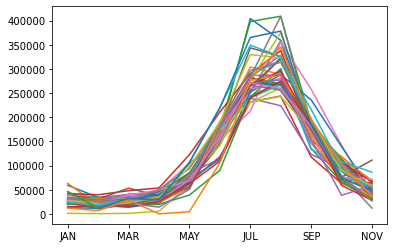

In [4]:
# do a plot just cause
nat_park_visits.loc["Mount Rainer National Park"][['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']].transpose()[:-1].plot(legend=False)

In [5]:
# collect all given years and parks from both the daily and overnight
parks = []
years = []
for dex in nat_park_visits.index[:]:
    if dex[0] not in parks:
        parks.append(dex[0])
    if dex[1] not in years:
        years.append(int(dex[1]))
for dex in  nat_park_overnight.index:
    if dex not in parks:
        parks.append(dex)
for year in nat_park_overnight['Year']:
    if year not in years:
        years.append(year)
print(parks)
# cut off the nan and All Years
years = years[:-2]
# sort years
years = sort(years)
print(years)

['Crater Lake', 'John Day Fossil Beds National Monument', 'Klondike Gold Rush National Recreation Area', 'Lake Chelan National Recreation Area', 'Lake Roosevelt National Recreation Area', 'Lewis and Clark National Historic Place', 'Mount Rainer National Park', 'North Cascades National Park', 'Olympic National Park', 'Oregon Caves National Park and National Monument', 'Ross Lake National Recreation Area', 'San Juan Island National Historic Park']
[1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992
 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006
 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020
 2021]


In [6]:
# also nab month names for manipulating the vists data
months=list(nat_park_visits.columns[1:-1])
print(months)

['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']


In [7]:
# Develop a new DataFrame so that we can have it as a timeseries
revised_nat_park_visits = pd.DataFrame(index=pd.date_range(start=f"{years[0]}", end=f'{years[-1]}', freq='MS'), columns=parks)
# collect where we throw errors
errors = []
for park in parks:
    for year in years:
        for month_num, month in enumerate(months):
            try:
                revised_nat_park_visits[park].loc[f'{year}-{month_num+1}-01'] = nat_park_visits.loc[park, year][month].values[0]
            except:
                errors.append((park, year, month))

# set types
for park in parks:
    revised_nat_park_visits[park] = revised_nat_park_visits[park].astype(float)

In [8]:
# did check, these errors are where there is no data, so we did things right above
# errors

In [9]:
# tada
revised_nat_park_visits

,Crater Lake,John Day Fossil Beds National Monument,Klondike Gold Rush National Recreation Area,Lake Chelan National Recreation Area,Lake Roosevelt National Recreation Area,Lewis and Clark National Historic Place,Mount Rainer National Park,North Cascades National Park,Olympic National Park,Oregon Caves National Park and National Monument,Ross Lake National Recreation Area,San Juan Island National Historic Park
1979-01-01,6771.0,295.0,0.0,NaN,2095.0,1498.0,24214.0,2556.0,48453.0,1158.0,NaN,6786.0
1979-02-01,5820.0,1886.0,0.0,NaN,2698.0,2809.0,15342.0,4350.0,38221.0,1142.0,NaN,4227.0
1979-03-01,10617.0,4978.0,0.0,NaN,13027.0,7088.0,40179.0,5465.0,75100.0,4617.0,NaN,6288.0
1979-04-01,11004.0,4829.0,0.0,NaN,30627.0,5547.0,43153.0,21066.0,105322.0,4815.0,NaN,5913.0
1979-05-01,21528.0,7883.0,0.0,NaN,73162.0,7406.0,65792.0,58174.0,130894.0,6806.0,NaN,6060.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-01,59093.0,9849.0,71.0,4589.0,134576.0,18737.0,195942.0,5023.0,334249.0,72.0,138272.0,55754.0
2020-10-01,61613.0,10050.0,331.0,2473.0,82377.0,18043.0,101916.0,1830.0,188318.0,624.0,127816.0,43146.0
2020-11-01,18270.0,3144.0,1368.0,1127.0,59911.0,12014.0,36523.0,18.0,107430.0,297.0,15950.0,31646.0
2020-12-01,26100.0,2663.0,0.0,1058.0,53923.0,8567.0,42198.0,2.0,80143.0,432.0,9040.0,36161.0


In [10]:
nat_park_visits_ds = xr.Dataset(
    coords = dict(
        time = revised_nat_park_visits.index,
        park = parks,
    ),
    data_vars=dict(
        day_visits=(["time","park"], revised_nat_park_visits.values)
    )
)
nat_park_visits_ds

<xarray.Dataset>
Dimensions:     (time: 505, park: 12)
Coordinates:
  * time        (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-01-01
  * park        (park) <U48 'Crater Lake' ... 'San Juan Island National Histo...
Data variables:
    day_visits  (time, park) float64 6.771e+03 295.0 0.0 ... 7.184e+03 2.612e+04

Success!! Did double check that I didn't transpose it weird and we good. Going to save this first version.

In [12]:
nat_park_visits_ds.attrs = {
    "Source": "https://irma.nps.gov/STATS/Reports/Park",
    "Original Download": "3/9/21 by K. Hegewisch",
    "Reformatted": "11/17/21 by A. Stein",
    "Notes" : "Lakes Ross and Chelan began being counted seperated from North Cascades National Park in 1991."
}

try:
    os.remove('/pool0/home/steinadi/data/drought/drought_impact/data/national_parks_v1.nc')
except:
    pass
nat_park_visits_ds.to_netcdf('/pool0/home/steinadi/data/drought/drought_impact/data/national_parks_v1.nc')

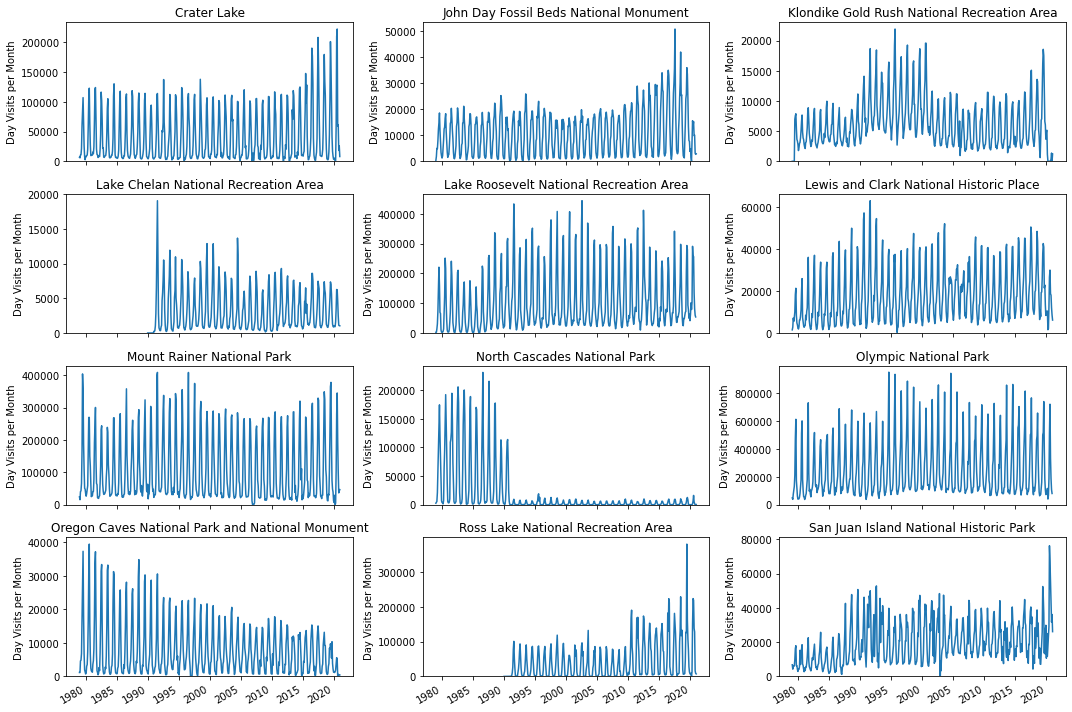

In [13]:
fig, axs = plt.subplots(4,3, figsize=(15,10), sharex=True)
ax_all = axs.ravel()

for ax, park in zip(ax_all, parks):
    nat_park_visits_ds['day_visits'].sel(park=park).plot(ax=ax)
    ax.set_title(park)
    ax.set_ylabel('Day Visits per Month')
    ax.set_xlabel('')
    ax.set_ylim(0,ax.get_ylim()[1])

plt.tight_layout()

Turns out, after 1991 Ross Lake and Lake Chelan were counted separately from North Cascades National Park, so if we combine all 3 we should get the complete picture

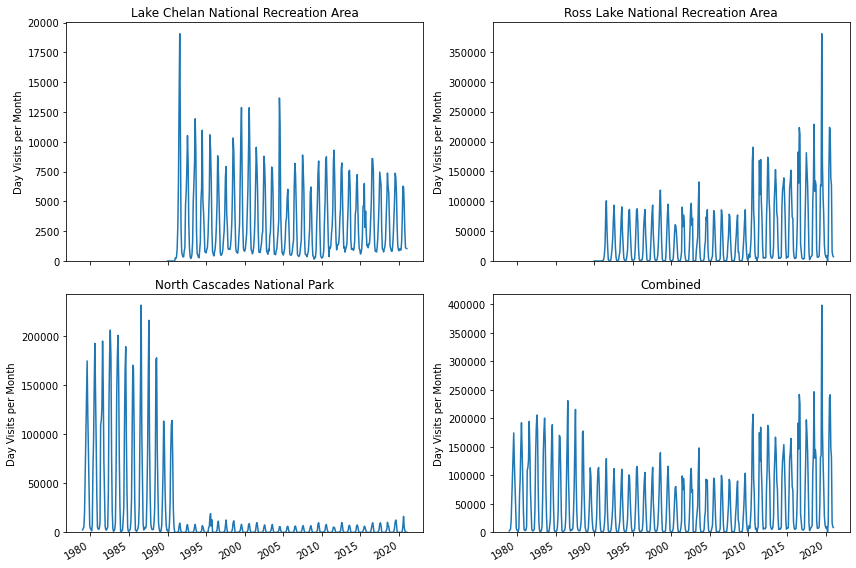

In [14]:
fig, axs = plt.subplots(2,2, figsize=(12,8), sharex=True)
ax_all = axs.ravel()

cascade_parks = ['Lake Chelan National Recreation Area', 'Ross Lake National Recreation Area',  'North Cascades National Park', 'Combined']

for ax, park in zip(ax_all, cascade_parks):
    if park != 'Combined':
        nat_park_visits_ds['day_visits'].sel(park=park).plot(ax=ax)
    else:
        nat_park_visits_ds['day_visits'].sel(park=cascade_parks[:-1]).sum(dim='park').plot(ax=ax)
    ax.set_title(park)
    ax.set_ylabel('Day Visits per Month')
    ax.set_xlabel('')
    ax.set_ylim(0,ax.get_ylim()[1])

plt.tight_layout()

## Now to add in the overnight data

In [15]:
nat_park_overnight

,State,Year,Month,Recreation Visitors,Non-Recreation Visitors,Concession Lodging,Tent Campers,RV Campers,Concession Camping,Backcountry Campers,Misc Campers,Total Overnight Stays
Park Name,,,,,,,,,,,,
Crater Lake,OR,1979.0,1979 Totals,410749.0,35648.0,18097.0,8320.0,34677.0,0.0,2692.0,0.0,63786.0
Crater Lake,OR,1979.0,April,11004.0,1311.0,0.0,0.0,0.0,0.0,189.0,0.0,189.0
Crater Lake,OR,1979.0,August,107031.0,5379.0,6362.0,2092.0,11858.0,0.0,768.0,0.0,21080.0
Crater Lake,OR,1979.0,December,2599.0,464.0,0.0,0.0,0.0,0.0,383.0,0.0,383.0
Crater Lake,OR,1979.0,February,5820.0,795.0,0.0,0.0,0.0,0.0,129.0,0.0,129.0
...,...,...,...,...,...,...,...,...,...,...,...,...
San Juan Island National Historic Park,WA,2020.0,May,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
San Juan Island National Historic Park,WA,2020.0,November,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
San Juan Island National Historic Park,WA,2020.0,October,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now this time we can't just make a new DataFrame because we have multiple variables and aren't just transposing like last time ... not to mention the individual totals in there. So instead we'll add it directly to the dataset

In [16]:
long_months = []
long_month_errors = []
for val in nat_park_overnight['Month']:
    try:
        if val not in long_months and "Totals" not in val and "Visitors" not in val:
            long_months.append(val)
    except:
        long_month_errors.append(val)
print(long_months)
print()
print(long_month_errors)

['April', 'August', 'December', 'February', 'January', 'July', 'June', 'March', 'May', 'November', 'October', 'September']

[2004.0, 1990.0, nan, 1982.0, 1983.0, 1986.0, 1987.0, 2003.0, nan]


Hmmm ... I think this is fine, will come back if issue

In [17]:
# to make life easier, since these are just the months
# spelled out I'm going to put them in an order that I
# can zip through their numbers later like we did before
long_months = ['January','February','March','April','May','June','July','August','September','October','November','December']
month_to_num = dict()
for num, month in enumerate(long_months):
    month_to_num[month] = num + 1
month_to_num  

{'January': 1,
 'February': 2,
 'March': 3,
 'April': 4,
 'May': 5,
 'June': 6,
 'July': 7,
 'August': 8,
 'September': 9,
 'October': 10,
 'November': 11,
 'December': 12}

In [18]:
'Lake Chelan National Recreation Area' in nat_park_overnight.index

True

In [19]:
# just popping off the state value and Month cause don't really need that
# added to our dataset as a variable
overnight_data = list(nat_park_overnight.columns)[2:]
overnight_data

['Month',
 'Recreation Visitors',
 'Non-Recreation Visitors',
 'Concession Lodging',
 'Tent Campers',
 'RV Campers',
 'Concession Camping',
 'Backcountry Campers',
 'Misc Campers',
 'Total Overnight Stays']

In [20]:
for o_data in overnight_data[1:]:
    nat_park_overnight[o_data] = nat_park_overnight[o_data].astype(float)

In [21]:
# check we get values
#for i in np.arange(len(nat_park_overnight.loc[parks[0]])):
#    try:
#        print(nat_park_overnight[overnight_data[1]].loc[parks[0]].iloc[i]).values
#    except:
#        pass

In [22]:
nat_park_ds = nat_park_visits_ds.copy()
nat_park_ds = nat_park_ds.rename({'day_visits':'Day Visits'})

for o_data in overnight_data[1:]:
    # setup the shape
    nat_park_ds[o_data] = np.nan*nat_park_ds['Day Visits'].copy()
    # go through and input data
    for park in parks:
        sel_data = nat_park_overnight.loc[park]
        for i in np.arange(len(sel_data)):
            # look up what year and month we have at this index
            year = sel_data['Year'].iloc[i]
            month = sel_data['Month'].iloc[i]
            # check that we aren't pulling one of the totals values
            if month in long_months:
                month_num = month_to_num[month]
                nat_park_ds[o_data].loc[f"{int(year)}-{month_num}-01", park] = sel_data[o_data].iloc[i]

# now note that we may not have at every time for every park, so nans exist where this happens
nat_park_ds

<xarray.Dataset>
Dimensions:                  (time: 505, park: 12)
Coordinates:
  * time                     (time) datetime64[ns] 1979-01-01 ... 2021-01-01
  * park                     (park) <U48 'Crater Lake' ... 'San Juan Island N...
Data variables:
    Day Visits               (time, park) float64 6.771e+03 295.0 ... 2.612e+04
    Recreation Visitors      (time, park) float64 6.771e+03 295.0 ... nan nan
    Non-Recreation Visitors  (time, park) float64 650.0 0.0 nan ... nan nan nan
    Concession Lodging       (time, park) float64 0.0 0.0 nan ... nan nan nan
    Tent Campers             (time, park) float64 0.0 0.0 nan ... nan nan nan
    RV Campers               (time, park) float64 0.0 0.0 nan ... nan nan nan
    Concession Camping       (time, park) float64 0.0 0.0 nan ... nan nan nan
    Backcountry Campers      (time, park) float64 68.0 0.0 nan ... nan nan nan
    Misc Campers             (time, park) float64 0.0 0.0 nan ... nan nan nan
    Total Overnight Stays    (time, park) float64 68.0 0.0 nan ... nan nan nan
Attributes:
    Source:             https://irma.nps.gov/STATS/Reports/Park
    Original Download:  3/9/21 by K. Hegewisch
    Reformatted:        11/17/21 by A. Stein
    Notes:              Lakes Ross and Chelan began being counted seperated f...

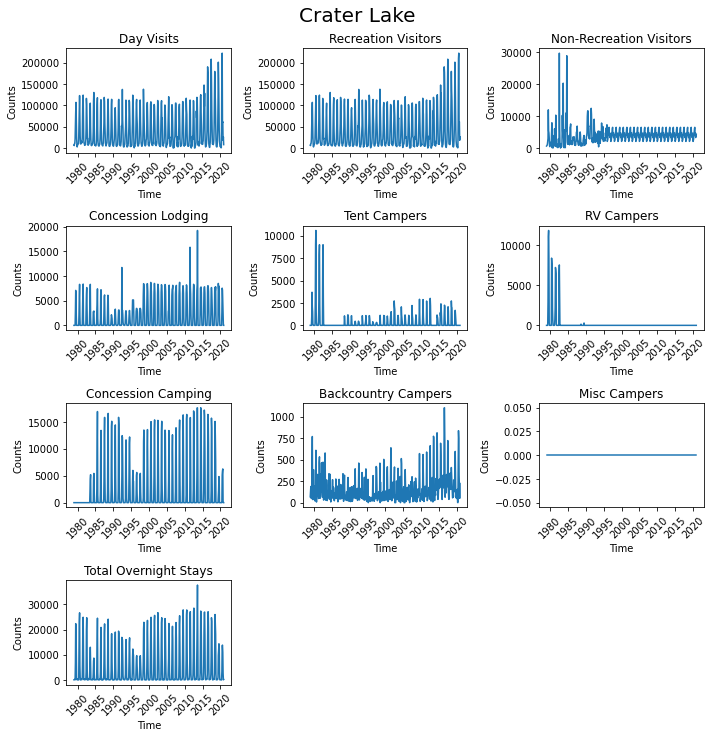

In [38]:
fig, axs = plt.subplots(4,3, figsize=(10,10))
ax = axs.ravel()

park = parks[0]

for i, var in enumerate(nat_park_ds.var()):
    ax[i].plot(nat_park_ds['time'].values, nat_park_ds[var].sel(park=park).values)
    ax[i].set_title(var)
    ax[i].tick_params(axis='x', rotation=45)
    ax[i].set_ylabel('Counts')
    ax[i].set_xlabel('Time')

i += 1
while i < len(ax):
    ax[i].axis('off')
    i += 1

fig.text(0.42, 1, park, fontsize=20)
plt.tight_layout()

In [26]:
try:
    os.remove('/pool0/home/steinadi/data/drought/drought_impact/data/national_parks_v2.nc')
except:
    pass
nat_park_ds.to_netcdf('/pool0/home/steinadi/data/drought/drought_impact/data/national_parks_v2.nc')